In [1]:
import itertools
import time

import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
import pathlib

from LoadData import LoadData
from sklearn.metrics import (auc, average_precision_score, accuracy_score, precision_recall_curve, 
                                classification_report, confusion_matrix, plot_confusion_matrix, 
                                f1_score, precision_score, recall_score, roc_curve)
from sklearn.model_selection import (cross_val_predict, GridSearchCV, train_test_split, learning_curve, validation_curve)
from sklearn.neural_network import MLPClassifier
from sklearn.utils import parallel_backend
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

random_state = 7
start = 10
max_iterations=1000
max_attempts=100
cv = 5
stop = 101
step = 10
size = 20
problem_name = "NeuralNetwork"
plt.style.use('ggplot')

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, 
                        cv=None, scoring='accuracy', n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    with parallel_backend('threading'):
        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           scoring=scoring,
                           return_times=True, verbose=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(True)
    axes[0].minorticks_on()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(True)
    axes[1].minorticks_on()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

    return plt


def plot_validation_curve(estimator,X, y, param_name, param_range, 
                          cv, n_jobs, title, xlabel, ylim = None, scoring='f1'):     
    with parallel_backend('threading'):
        train_scores, test_scores = validation_curve(
            estimator, X, y, param_name, param_range, cv=cv,
            scoring=scoring, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("F1 Score")

    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)    
    plt.plot(param_range,train_scores_mean-test_scores_mean, label = 'Error'
                    , color="red", lw=lw)

    plt.legend(loc="best")

    plt.show()


def plot_roc_curve(clf, X_test, y_test, title, dfunc=False):
    
    if dfunc:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
       
    fpr, tpr, threshold = roc_curve(y_test, y_score)      
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                             ''.format(roc_auc), linewidth=2.5)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    plt.show()

    optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    optimal_threshold = threshold[optimal_idx]
    print("Optimal Threshold: ")
    print(optimal_threshold)    

    
def plot_pr_curve(clf, X_test, y_test, title, dfunc=False):
    if dfunc:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
    
    with parallel_backend('threading'):
        average_precision = average_precision_score(y_test, y_score)
        precision, recall, threshold = precision_recall_curve(y_test, y_score)

    plt.plot(recall, precision, label='Precision Recall curve (AP = {0:0.2f})'
                             ''.format(average_precision),
             linewidth=2.5)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
       
    max_f1 = 0
    for r, p, t in zip(recall, precision, threshold):
        if p + r == 0: continue
        if (2 * p * r) / (p + r) > max_f1:
            max_f1 = (2 * p * r) / (p + r)
            max_f1_threshold = t

    print("Optimal Threshold: ") 
    print(max_f1_threshold)
    print("Maximized F1 score: ") 
    print(max_f1)


def plot_precision_recall_vs_threshold(clf, X_test, y_test, title, dfunc=False):
    if dfunc:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]

    with parallel_backend('threading'):
        average_precision = average_precision_score(y_test, y_score)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)
    
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.legend(loc='best')
    
def ConvertFrom1HToIndex(arr):
    results = np.argwhere(arr==1)
    return np.vstack(results[:,1])
    

### Load Dataset

In [3]:
cwd = pathlib.Path().absolute()
training_data_path = "{}/mnist-train-data.csv".format(cwd)
# testing_data_path = "{}/medium-mnist-test-data.csv".format(cwd)


training_labels, training_data, training_combined = LoadData(training_data_path, normalize=False)
# testing_labels, testing_data, testing_combined = LoadData(testing_data_path, normalize=False)

Attempting to load: mnist-train-data.csv

Loading Complete
Data Statistics: 
   Number of Entries: 3000 
   Shape of Entry: (785,)



### Neural Network - Randomized Optimization

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels,
                                                    test_size = 0.2, random_state = random_state)


# Normalize feature data
scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

# print("Y_Test_Hot: \n", y_test_hot.shape)
# print("\nTraining Labels: \n", training_labels.shape)
# print("\nTraining Data: \n", training_data.shape)


# print("\nX Train: \n", X_train.shape)
# print("\ny Train: \n", y_train.shape)
# print("\nX Test: \n", X_test.shape)
# print("\ny Test: \n", y_test.shape)

In [5]:
algorithm_list = ["random_hill_climb", "simulated_annealing", "genetic_alg", "gradient_descent"]
curve_list = []
accuracy_training_list = []
f1_training_list = []

accuracy_testing_list = []
f1_testing_list = []
time_list = []
classifiers = {"random_hill_climb": None, "simulated_annealing": None, "genetic_alg": None, "gradient_descent": None}

simulated_annealing
Starting to fit simulated_annealing
Finished Fitting simulated_annealing

Training Accuracy (simulated_annealing):  0.7704166666666666
Testing Accuracy (simulated_annealing):  0.7
Fit Runtime (simulated_annealing): 838.9039990901947sec

[learning_curve] Training set sizes: [ 600 1140]
[CV]  ................................................................[CV]  ................................................................[CV]  ................................................................


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV] ................ , score=(train=0.847, test=0.636), total= 9.3min


[Parallel(n_jobs=-1)]: Done   1 out of   4 | elapsed:  9.3min remaining: 28.0min


[CV] ................ , score=(train=0.872, test=0.679), total= 9.4min
[CV] ................ , score=(train=0.815, test=0.699), total=11.5min
[CV] ................ , score=(train=0.806, test=0.674), total=11.5min
Plotting Time: 691.1579990386963

Total Runtime (simulated_annealing): 1530.061998128891sec



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 11.5min finished


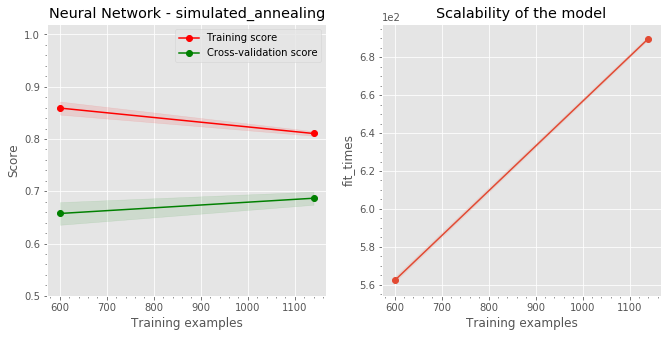

In [6]:
algorithm="simulated_annealing"
print(algorithm)
fig2, axes2 = plt.subplots(1, 2, figsize=(11, 5))
neural_network3 = mlrose.NeuralNetwork(hidden_nodes = [100], activation='relu', algorithm=algorithm,
                       max_iters=20000,bias=True,is_classifier=True,max_attempts=30,
                       early_stopping=True,clip_max = 1,
                       learning_rate=1,random_state = random_state,curve = True, schedule= mlrose.GeomDecay(decay=0.9))

start_time = time.time()
# Fit the neural network
with parallel_backend('threading'):
    print("Starting to fit {}".format(algorithm))
    neural_network3.fit(X_train_scaled, y_train_hot)
print("Finished Fitting {}\n".format(algorithm))
end_time = time.time()
elapsed_time = end_time - start_time
classifiers[algorithm] = [neural_network3, elapsed_time]
title="Neural Network - {}".format(algorithm)

# Predict labels for train set and assess accuracy
y_train_pred = neural_network3.predict(X_train_scaled)

y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)

print("Training Accuracy ({}): ".format(algorithm), y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = neural_network3.predict(X_test_scaled)

y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
print("Testing Accuracy ({}): ".format(algorithm), y_test_accuracy)
print("Fit Runtime ({}): {}sec\n".format(algorithm, elapsed_time))


plot_learning_curve(neural_network3, title, X_train_scaled, y_train_hot, axes=axes2, ylim=(0.5, 1.02),
                cv=2, scoring='accuracy', train_sizes=[0.5, 0.95])
total_end = time.time()
total_time = (total_end-start_time)
print("Plotting Time: {}\n".format((total_end - end_time)))
print("Total Runtime ({}): {}sec\n".format(algorithm, total_time))
time_list.append(elapsed_time)
plt.savefig("Learning_Curve_{}.png".format(algorithm))
plt.show()